<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"></ul></div>

In [1]:
push!(LOAD_PATH, ".")
using RobustOptimization
using Ipopt, JuMP, PyPlot
using ScikitLearn
@sk_import model_selection: train_test_split
@sk_import metrics: roc_curve
@sk_import metrics: roc_auc_score
path_train = "datasets/w8a"
path_test = "datasets/w8a.t"
nbfeatures = 300
data_train = read_data_libsvm(path_train, nbfeatures)
df_test = read_data_libsvm(path_test, nbfeatures);
srand(37)
df_train, df_aux = create_data("w8a", nbfeatures, 0.1, train_test_split);

In [2]:
solver = IpoptSolver(print_level = 0)
N = size(df_train)[1]
ϵ = 0.1
verbosity = 1
itmax = 100
sample = 500

ambiguity = "KLdivergence"
robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
α = 1/norm(robustModel.descent_direction)
projParams = ProjParams(Int(10), 1e-5, sample, para_proj=Sequential(), para_inter=Sequential())
optParams = OptParams(itmax, 1e-5, α, verbosity = verbosity);

In [3]:
xnormal = normal_opt(df_train, solver, robustModel.regressionModel)
fpr, tpr, thresholds = roc_curve(df_test[:,end], positive_rate(xnormal,df_test))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



([0.0, 0.00131062, 0.00144858, 0.00144858, 0.00151756, 0.00151756, 0.00165551, 0.00165551, 0.00165551, 0.00165551  …  0.992895, 0.993033, 0.993516, 0.993654, 0.997793, 0.997931, 0.998758, 0.998896, 0.999379, 1.0], [0.0, 0.242291, 0.242291, 0.251101, 0.251101, 0.253304, 0.253304, 0.257709, 0.264317, 0.268722  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  3.86537e-206, 3.83423e-207, 8.78622e-213, 5.24709e-213, 1.92996e-255, 1.04944e-257, 3.94316e-277, 4.01282e-282, 7.22349e-305, 0.0])

In [23]:
# dm_tab = []
# xr1_tab = []
# xr2_tab = []
# fpr1_tab = []
# tpr1_tab = []
# fpr2_tab = []
# tpr2_tab = []
# for ϵ in [0.001,0.005,0.01,0.05,0.1,0.5,1.0]
for ϵ in [0.05,0.1,0.5,1.0]
# for ϵ in [0.05]
    println(" ")
    println("espilon = ", ϵ)
    println(" ")
    robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
    x0 = ones(robustModel.descent_direction)
    xalg, yalg, dm, mem, mini = run_algo(x0, df_train, robustModel, optParams, projParams)
    xrobust1 = getsolution(xalg, ambiguity, nbfeatures)
    xrobust2 = getsolution(mem, ambiguity, nbfeatures)
    fpr1, tpr1, thresholds = roc_curve(df_test[:,end], positive_rate(xrobust1,df_test))
    fpr2, tpr2, thresholds = roc_curve(df_test[:,end], positive_rate(xrobust2,df_test))
    push!(dm_tab, dm)
    push!(xr1_tab, xrobust1)
    push!(xr2_tab, xrobust2)
    push!(fpr1_tab, fpr1)
    push!(tpr1_tab, tpr1)
    push!(fpr2_tab, fpr2)
    push!(tpr2_tab, tpr2)
end

 
espilon = 0.05
 
1 20799.374386793213 2 75.70554593782938 3 73.15798102465335 4 6.408382503838822 5 0.4595760599233025 6 1.0530920847848741 7 0.10776786951130579 8 0.6342559089717321 9 0.3403045795893409 10 0.26489340279549856 11 0.43484223679222 12 0.23012430678624596 13 0.31590994009326456 14 0.44209508825548105 15 0.15376379087273784 16 0.11603315595433128 17 0.5635661361439948 18 0.16922250982431453 19 0.2754685417199103 20 0.25293817398410234 21 0.2734642568253576 22 0.11289339954848687 23 0.2828435488106229 24 0.1061940023712471 25 0.1997529295576137 26 0.1647405486524971 27 0.07304233887938127 28 0.3115853692004926 29 0.056657318886480734 30 0.08336198986072163 31 0.2899611920279843 32 0.14268007401944804 33 0.08974564101860172 34 0.1691727193989343 35 0.23104989983556457 36 0.13919503692391255 37 0.07711662852815038 38 0.045914335503019155 39 0.14734091183685605 40 0.13262736359605354 41 0.07820823149133371 42 0.1900508727804595 43 0.05681201039362538 44 0.07513835082132014 4

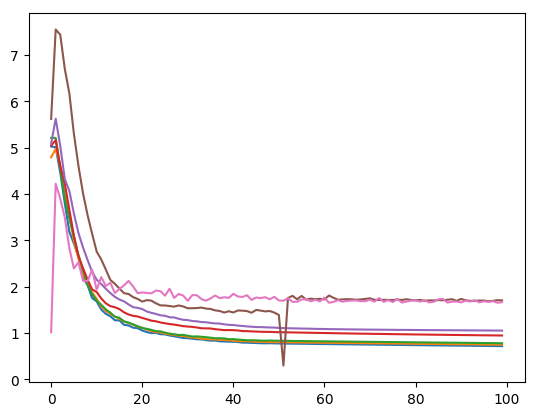

In [24]:
for i in 1:7
     plot(dm_tab[i])
end

In [1]:
plot(fpr,tpr, color="black")
for i in 1:7
     plot(fpr1_tab[i], tpr1_tab[i])
end

LoadError: [91mUndefVarError: plot not defined[39m

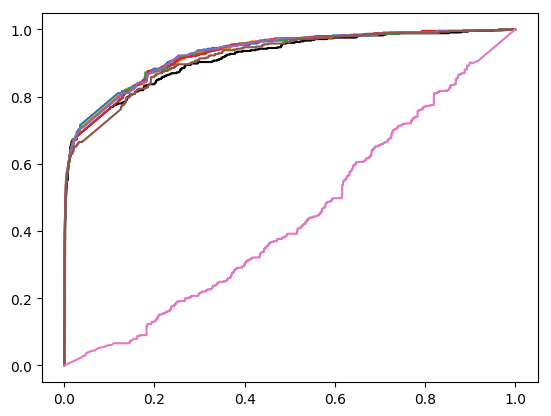

In [26]:
plot(fpr,tpr, color="black")
for i in 1:7
     plot(fpr2_tab[i], tpr2_tab[i])
end

In [27]:
println(roc_auc_score(df_test[:,end], positive_rate(xnormal,df_test)))
for i in 1:7
    println(roc_auc_score(df_test[:,end], positive_rate(xr1_tab[i],df_test)))
end

0.9150318659276004
0.9303786534598226
0.9283966240622774
0.9284624131561172
0.9273839582183038
0.9289907010990273
0.9286646424491897
0.9351420573419565


In [28]:
println(roc_auc_score(df_test[:,end], positive_rate(xnormal,df_test)))
for i in 1:7
    println(roc_auc_score(df_test[:,end],positive_rate(xr2_tab[i],df_test)))
end

0.9150318659276004
0.9303786534598226
0.9283966240622774
0.9284624131561172
0.9273839582183038
0.9289907010990273
0.9172806982091692
0.4411547702866673


In [34]:
open("w8a.txt", "w") do f
    write(f, "xnormal = ")
    write(f, "$xnormal \n")
    write(f, "fpr = ")
    write(f, "$fpr \n")
    write(f, "tpr = ")
    write(f, "$tpr \n")
    write(f, "dm_tab = ")
    write(f, "$dm_tab \n")
    write(f, "xr1_tab = ")
    write(f, "$xr1_tab \n")
    write(f, "fpr1_tab = ")
    write(f, "$fpr1_tab \n")
    write(f, "tpr1_tab = ")
    write(f, "$tpr1_tab \n")
end

121837